In [1]:
import numpy as np

from types import SimpleNamespace

import Modules.pauli as pauli
import Modules.Ham_MX2_11_band as H
import Modules.TB_parameters as tb

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def color_plot(func, kmax=1.0, N=30, center=(0, 0), circular=True, vmin=0, vmax=None,
              xlabel=r'$k_x a$', ylabel=r'$k_y a$', clabel=r'eV', title=r' '):
    """Plot the output of the function func on a mesh in k-space centered at
    the point 'center', with either a circular or a square mesh. """
    
    def evaluate_on_grid(X, Y, func):
        """ X, Y should be in np.meshgrid form. It's enough for func to work on floats. """
        data = []
        for xx, yy in zip(X, Y):
            data.append([func(i,j) for i, j in zip(xx, yy)])
        data = np.array(data)
        return data
    
    if circular:
        # Generate a circular mesh
        r = np.linspace(0, kmax, N)
        phi = np.linspace(0, 2*np.pi, N)
        r, phi = np.meshgrid(r, phi)
        x, y = r*np.cos(phi) + center[0], r*np.sin(phi) + center[1]
    else: # square mesh
        kxs = np.linspace(-kmax + center[0], kmax + center[0], N)
        kys = np.linspace(-kmax + center[1], kmax + center[1], N)
        x, y = np.meshgrid(kxs, kys)

    fvals = evaluate_on_grid(x, y, func=func)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1)
    plt.pcolor(x-center[0], y-center[1], fvals, cmap='inferno', vmin=vmin, vmax=vmax)
    plt.colorbar().set_label(label=clabel, size=20)
    ax.set_title(title)
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)

## Check whether the spin split conduction band is even under a sign flip in $k_x$ and/or $k_y$ around the $K$ points with SC included and the chemical potential just below the conduction band minimum.

In [3]:
def check_even_cond(p, flip_kx=True, flip_ky=True, spin=True, SC=False, bands=(20, 24)):
    def func(kx, ky):
        if flip_kx:
            skx = -1
        else:
            skx = 1
        if flip_ky:
            sky = -1
        else:
            sky = 1
        if SC:
            # With the chemical potential just below the conduction band,
            # states 22:24 around the K point are the lowest spin-split
            # conduction band. 20:24 then gives its hole partners as well.
            if bands is None:
                E1 = H.energies(kx, ky, p, spin=spin, SC=SC)
                E2 = H.energies(skx*kx, sky*ky, p, spin=spin, SC=SC)
            else:
                E1 = H.energies(kx, ky, p, spin=spin, SC=SC)[bands[0]:bands[1]]
                E2 = H.energies(skx*kx, sky*ky, p, spin=spin, SC=SC)[bands[0]:bands[1]]
        else:
            E1 = H.energies(kx, ky, p, spin=spin, SC=SC)
            E2 = H.energies(skx*kx, sky*ky, p, spin=spin, SC=SC)
        return np.linalg.norm(E1 - E2)
    return func

In [4]:
# SOI strengths, superconducting pairing
p = SimpleNamespace(mu=1.77, Delta=0.2e-3, lambda_M=0.0836, lambda_X=0.0556, Ex=0.05e-3, Ey=0.0)

In [5]:
# Chemical potential just below the conduction band
kmax = 2.0
N = 75

In [6]:
p

namespace(Delta=0.0002, Ex=5e-05, Ey=0.0, lambda_M=0.0836, lambda_X=0.0556, mu=1.77)

In [7]:
center = tb.Kp

In [8]:
p.mu = 0
H.energies(center[0], center[1], p, spin=True, SC=True)[20:28]

array([-0.10635448, -0.03806259,  0.03806259,  0.10635448,  1.76745257,
        1.77481429,  2.05430095,  2.07700776])

In [9]:
p.mu = 1.77
H.energies(center[0], center[1], p, spin=True, SC=True)[20:24]

array([-0.00481843, -0.00255528,  0.00255528,  0.00481843])

If a Zeeman field is included only along either $x$ or $y$, the spectrum (all bands) satisfies $E(k_x, k_y) = E(k_x, -k_y) = E(-k_x, k_y)$ in the entire Brillouin zone.

In [10]:
bands = None

In [11]:
p.Ey = 0; p.Ex = 0.05

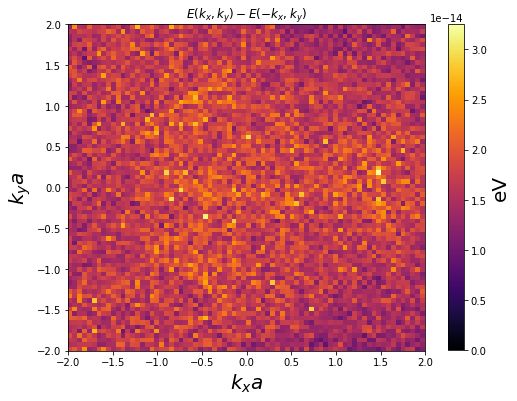

In [12]:
color_plot(check_even_cond(p, flip_ky=False, SC=True, bands=bands), center=center, kmax=kmax, N=N, circular=False,
           vmin=0, vmax=None, xlabel=r'$k_x a$', ylabel=r'$k_y a$', clabel=r'eV',
           title=r'$E(k_x, k_y) - E(-k_x, k_y)$')

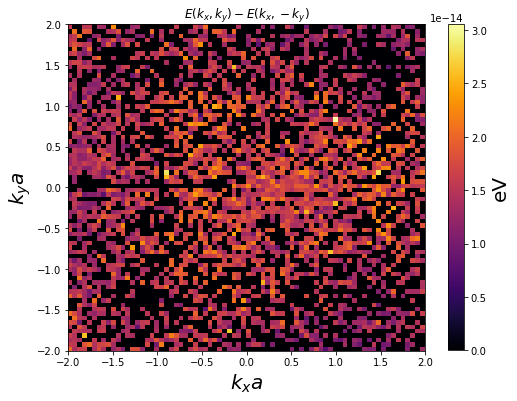

In [13]:
color_plot(check_even_cond(p, flip_kx=False, SC=True, bands=bands), center=center, kmax=kmax, N=N, circular=False,
           vmin=0, vmax=None, xlabel=r'$k_x a$', ylabel=r'$k_y a$', clabel=r'eV',
           title=r'$E(k_x, k_y) - E(k_x, -k_y)$')

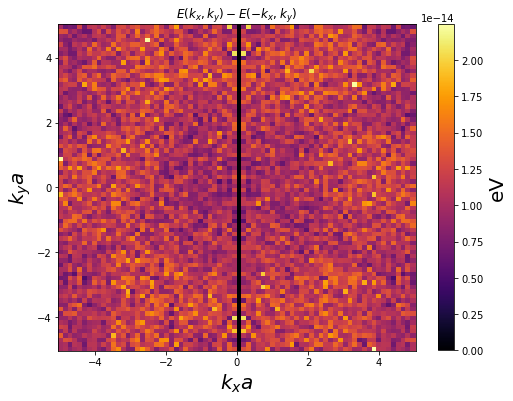

In [14]:
color_plot(check_even_cond(p, flip_ky=False, SC=False, bands=bands), center=(0, 0), kmax=1.2*4.*np.pi/3,
           N=N, circular=False, vmin=0, vmax=None, xlabel=r'$k_x a$', ylabel=r'$k_y a$', clabel=r'eV',
           title=r'$E(k_x, k_y) - E(-k_x, k_y)$')

In [15]:
p.Ey = 0.06; p.Ex = 0.0

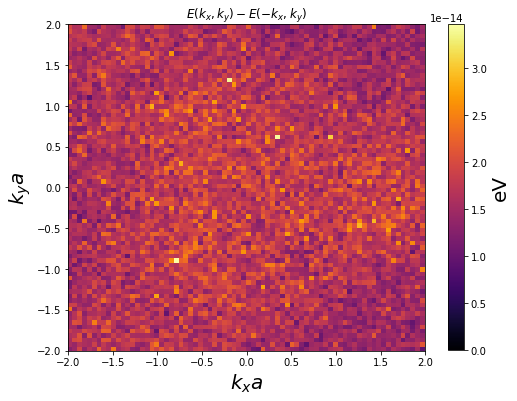

In [16]:
color_plot(check_even_cond(p, flip_ky=False, SC=True, bands=bands), center=center, kmax=kmax, N=N, circular=False,
           vmin=0, vmax=None, xlabel=r'$k_x a$', ylabel=r'$k_y a$', clabel=r'eV',
           title=r'$E(k_x, k_y) - E(-k_x, k_y)$')

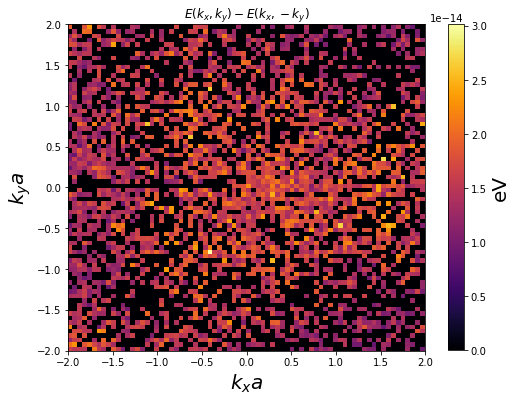

In [17]:
color_plot(check_even_cond(p, flip_kx=False, SC=True, bands=bands), center=center, kmax=kmax, N=N, circular=False,
           vmin=0, vmax=None, xlabel=r'$k_x a$', ylabel=r'$k_y a$', clabel=r'eV',
           title=r'$E(k_x, k_y) - E(k_x, -k_y)$')

If both magnetic field components are nonzero, the evenness in the spectrum is lost. The following includes all bands:

In [18]:
bands = None
p.Ex = 0.0009; p.Ey = 0.001

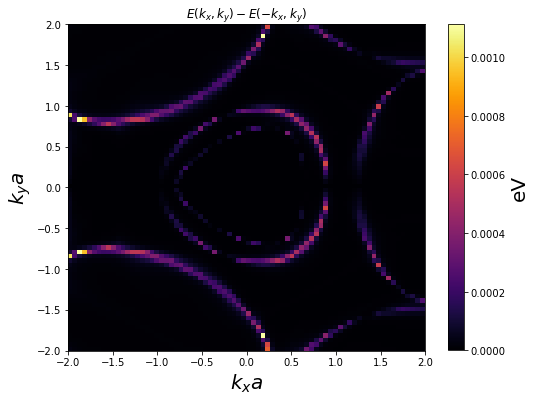

In [19]:
color_plot(check_even_cond(p, flip_ky=False, SC=True, bands=bands), center=center, kmax=kmax, N=N, circular=False,
           vmin=0, vmax=None, xlabel=r'$k_x a$', ylabel=r'$k_y a$', clabel=r'eV',
           title=r'$E(k_x, k_y) - E(-k_x, k_y)$')

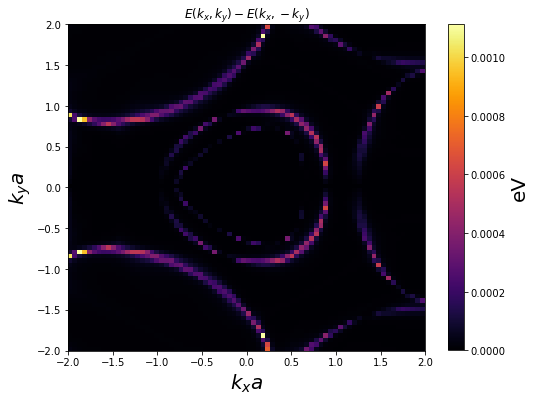

In [20]:
color_plot(check_even_cond(p, flip_kx=False, SC=True, bands=bands), center=center, kmax=kmax, N=N, circular=False,
           vmin=0, vmax=None, xlabel=r'$k_x a$', ylabel=r'$k_y a$', clabel=r'eV',
           title=r'$E(k_x, k_y) - E(k_x, -k_y)$')

If we only consider the lowest conduction band (both spin split bands, both electron and hole bands), the evenness is somewhat better, but still broken by the magnetic field.

In [21]:
bands = (20, 24)

In [22]:
p

namespace(Delta=0.0002, Ex=0.0009, Ey=0.001, lambda_M=0.0836, lambda_X=0.0556, mu=1.77)

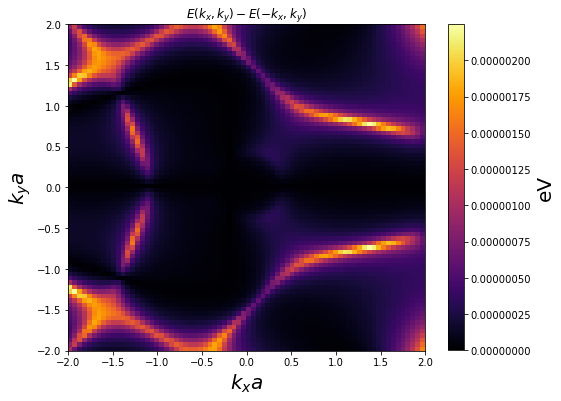

In [23]:
color_plot(check_even_cond(p, flip_ky=False, SC=True, bands=bands), center=center, kmax=kmax, N=N, circular=False,
           vmin=0, vmax=None, xlabel=r'$k_x a$', ylabel=r'$k_y a$', clabel=r'eV',
           title=r'$E(k_x, k_y) - E(-k_x, k_y)$')

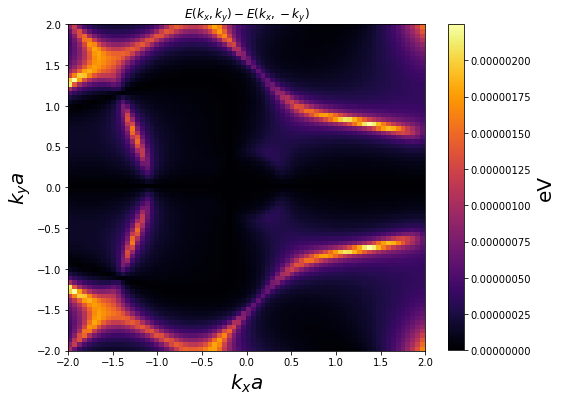

In [24]:
color_plot(check_even_cond(p, flip_kx=False, SC=True, bands=bands), center=center, kmax=kmax, N=N, circular=False,
           vmin=0, vmax=None, xlabel=r'$k_x a$', ylabel=r'$k_y a$', clabel=r'eV',
           title=r'$E(k_x, k_y) - E(k_x, -k_y)$')

In the NbSe$_2$ paper, the 1D particle-hole symmetry in the continuum limit is constructed from the full $2D$ particle-hole symmetry $\mathcal{P} = \tau_x K$ and the observation that $H(k_x, k_y) = H(k_x, -k_y)$, i.e. $\mathcal{P} H(k_x, k_y) \mathcal{P}^{-1} = -H(-k_x, -k_y) = -H(-k_x, k_y)$.

Check whether the Hamiltonian is invariant under $k_y \rightarrow -k_y$.

In [26]:
kx, ky = tb.Kp + np.random.rand(2)
ky

0.41604084701043703

In [27]:
# Field alignment doesn't help here
p.Ey = 0; p.Ex = 0.0

In [28]:
HamP = H.full_Hamiltonian(kx, ky, p, SC=True)
HamN = H.full_Hamiltonian(kx, -ky, p, SC=True)

In [29]:
# Vanishes if identical
np.linalg.norm(HamP - HamN)

6.6231245182672147

In [30]:
# Energies at (kx, ky) and (kx, -ky) are still the same (if the field is along a single axis only)
np.allclose(np.linalg.eigh(HamP)[0], np.linalg.eigh(HamN)[0])

True

# Check the symmetry of an 'effective' TB Ham for the lowest spin-split conduction band (and particle-hole partners)

For the 1D symmetry, we need $H(k_x, k_y) = H(k_x, -k_y)$. This is not the case in the 11 band TB model, although the spectrum has this symmetry if the Zeeman field is aligned with either x or y (and approximately for orientations in between).

Try to project out the lowest (spin split) conduction band and check whether such an effective Hamiltonian satisfies the constraint. The spin split conduction bands and their particle-hole partners gives a total of 4 bands to include.

Doesn't seem to give the desired constraint. Since the projection relies on diagonalizing the Hamiltonian, the effects of remote bands are still included here!

In [5]:
# SOI strengths, superconducting pairing
p = SimpleNamespace(mu=1.77, Delta=0.2e-3, lambda_M=0.0836, lambda_X=0.0556, Ex=0.05e-3*0, Ey=0.0)

In [6]:
p

namespace(Delta=0.0002, Ex=0.0, Ey=0.0, lambda_M=0.0836, lambda_X=0.0556, mu=1.77)

In [7]:
def H_C_eff(kx, ky, p, extended_hopping=True):
    """Returns an effective Hamiltonian for the lowest spin split conduction band, including
    particle-hole partners. Holes included as well. A chemical potential close to (or in) the conduction
    band is assumed."""
    Ham = H.full_Hamiltonian(kx, ky, p, extended_hopping=extended_hopping, spin=True, SC=True)
    assert np.allclose(Ham, Ham.T.conj())
    Es, U = np.linalg.eigh(Ham)
    proj = U[:, 20:24].dot(U[:, 20:24].T.conj())
    assert np.allclose(U.dot(U.T.conj()), np.eye(U.shape[0]))
    assert np.allclose(proj.T.conj(), proj)
    H_eff = proj.dot(Ham).dot(proj)
    return H_eff

In [8]:
kx, ky = tb.Kp + np.random.rand(2)
ky

0.13407565572555077

In [11]:
np.linalg.eigh(Heff)[0]

array([ -1.98404338e-01,  -1.83647374e-01,  -1.05020679e-16,
        -8.02464066e-17,  -7.85300759e-17,  -6.71004670e-17,
        -5.28397599e-17,  -5.22168692e-17,  -5.09663542e-17,
        -4.54158516e-17,  -2.98200147e-17,  -2.29166760e-17,
        -2.27067459e-17,  -1.64584186e-17,  -1.39949302e-17,
        -8.66949484e-18,  -6.15088492e-18,  -5.66177383e-18,
        -1.15722502e-18,  -4.08249086e-19,  -5.70751272e-20,
        -4.20359223e-20,  -1.61775949e-20,   4.73674753e-20,
         2.42016543e-19,   1.29186806e-18,   2.55645080e-18,
         7.14044983e-18,   1.09975462e-17,   1.17969088e-17,
         1.84871968e-17,   2.04902387e-17,   2.43681581e-17,
         3.23261783e-17,   4.52477084e-17,   4.64885487e-17,
         4.88056126e-17,   6.10121083e-17,   7.60441420e-17,
         7.75979467e-17,   8.89949908e-17,   1.06078085e-16,
         1.83647374e-01,   1.98404338e-01])

In [9]:
Heff = H_C_eff(kx, ky, p)

In [37]:
Heff3 = H_C_eff(-kx, -ky, p)

In [38]:
Heff4 = H_C_eff(-kx, ky, p)

In [39]:
Heff2 = H_C_eff(kx, -ky, p)

In [40]:
P = H.P

In [41]:
# Check how much the Hamiltonian changes under ky => -ky
np.linalg.norm(Heff - Heff2)

0.60905501933108963

In [42]:
# Check the mirror symmetry - this one should vanish identically
M2 = H.M2
np.linalg.norm(M2.dot(Heff).dot(M2) - Heff4)

1.6868122926943401e-15

In [43]:
# Check 2D particle-hole symmetry - should also vanish identically.
np.linalg.norm(P.dot(Heff.conj()).dot(P) + Heff3)

2.5561590153354239e-15